# Melbourne Housing Price Prediction Regression Report


## 1. Task overview
- dataset: Melbourne_housing_FULL.csv
- target: price
- process:
1. Data acquisition & feature engineering
2. EDA: price distributions & trends
3. Preprocessing: one-hot encoding, scaling
4. Models: Linear Regression, RidgeCV, RandomForest, GradientBoosting
5. Evaluation: MAE, RMSE, R^2 (k-fold CV)
6. Feature importance (permutation)
7. Deployment (Streamlit)


## 2. Data Loading & EDA

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

df = pd.read_csv("Melbourne_housing_FULL.csv")
df['Date'] = pd.to_datetime(df.get('Date'), dayfirst=True, errors='coerce')
df['SaleYear'] = df['Date'].dt.year
df['SaleMonth'] = df['Date'].dt.month
if 'YearBuilt' in df.columns:
    df['AgeAtSale'] = np.where(df['SaleYear'].notna() & df['YearBuilt'].notna(), df['SaleYear'] - df['YearBuilt'], np.nan)
for col in ['Landsize','BuildingArea','Propertycount']:
    if col in df.columns: df[f'log1p_{col}'] = np.log1p(df[col])
if all(c in df.columns for c in ['Rooms','Bathroom']):
    df['Rooms_x_Bath'] = df['Rooms'] * df['Bathroom']

df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Longtitude,Regionname,Propertycount,SaleYear,SaleMonth,AgeAtSale,log1p_Landsize,log1p_BuildingArea,log1p_Propertycount,Rooms_x_Bath
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,2016-09-03,2.5,3067.0,...,144.9958,Northern Metropolitan,4019.0,2016,9,NaN,4.844187,NaN,8.299037,2.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-12-03,2.5,3067.0,...,144.9984,Northern Metropolitan,4019.0,2016,12,NaN,5.313206,NaN,8.299037,2.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,2016-02-04,2.5,3067.0,...,144.9934,Northern Metropolitan,4019.0,2016,2,116.0,5.056246,4.382027,8.299037,2.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,2016-02-04,2.5,3067.0,...,145.0116,Northern Metropolitan,4019.0,2016,2,NaN,0.000000,NaN,8.299037,6.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,2017-03-04,2.5,3067.0,...,144.9944,Northern Metropolitan,4019.0,2017,3,117.0,4.905275,5.017280,8.299037,6.0


### 2.1 Visualization

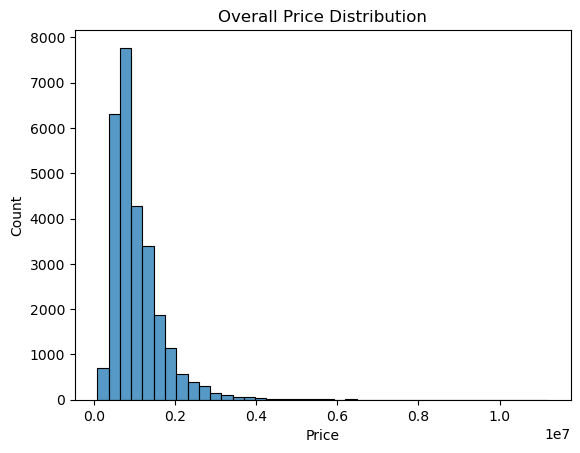

In [2]:
import seaborn as sns

sns.histplot(df['Price'].dropna(), bins=40)
plt.title("Overall Price Distribution")
plt.show()

## 3. Preprocessing

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

num_features = ['Rooms','Distance','Bedroom2','Bathroom','Car',
                'Landsize','BuildingArea','YearBuilt','Lattitude',
                'Longtitude','Propertycount','SaleYear','SaleMonth',
                'AgeAtSale','log1p_Landsize','log1p_BuildingArea',
                'log1p_Propertycount','Rooms_x_Bath','Postcode']
cat_features = ['Suburb','Type','Method','SellerG','CouncilArea','Regionname']

X = df[num_features + cat_features].copy()
y = df['Price'].copy().dropna()
X = X.loc[y.index]

numeric_transformer = Pipeline([
    ('impute', FunctionTransformer(lambda a: np.where(np.isnan(a), np.nanmedian(a, axis=0), a), validate=False)),
    ('scale', StandardScaler(with_mean=False))
])
categorical_transformer = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=True))
])
preprocess = ColumnTransformer([
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((21797, 25), (5450, 25))

## 4. Model Training & Cross-Validation

In [4]:
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import math, pandas as pd

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

scorers = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'RMSE': make_scorer(lambda yt, yp: rmse(yt, yp), greater_is_better=False),
    'R2': make_scorer(r2_score)
}

models = {
    "LinearRegression": LinearRegression(),
    "RidgeCV": RidgeCV(alphas=np.logspace(-3, 3, 13)),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

kfold = KFold(n_splits=3, shuffle=True, random_state=42)
rows = []

for name, model in models.items():
    pipe = Pipeline([('preprocess', preprocess), ('model', model)])
    cv_results = cross_validate(pipe, X, y, scoring=scorers, cv=kfold, n_jobs=1)
    rows.append({
        'Model': name,
        'MAE': -cv_results['test_MAE'].mean(),
        'RMSE': -cv_results['test_RMSE'].mean(),
        'R2': cv_results['test_R2'].mean()
    })
metrics_df = pd.DataFrame(rows).sort_values(by='RMSE')
metrics_df

C:\Users\hoang\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\hoang\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\hoang\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\hoang\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. 

,Model,MAE,RMSE,R2
2,RandomForest,169249.481870,303628.442836,0.775904
3,GradientBoosting,191687.427292,325511.522257,0.742472
0,LinearRegression,231053.494366,412535.282193,0.574798
1,RidgeCV,228699.089280,412776.112587,0.573528


## 5. Feature Importance

In [5]:
from sklearn.inspection import permutation_importance

best_model_name = metrics_df.iloc[0]['Model']
best_est = models[best_model_name]
best_pipe = Pipeline([('preprocess', preprocess), ('model', best_est)]).fit(X_train, y_train)
perm = permutation_importance(best_pipe, X_test, y_test, n_repeats=3, random_state=42, n_jobs=1)
ohe = best_pipe.named_steps['preprocess'].named_transformers_['cat'].named_steps['ohe']
feature_names_all = num_features + list(ohe.get_feature_names_out(cat_features))

fi_df = pd.DataFrame({
    'feature': feature_names_all[:len(perm.importances_mean)],
    'importance_mean': perm.importances_mean[:len(feature_names_all)],
}).sort_values(by='importance_mean', ascending=False).head(20)
fi_df

C:\Users\hoang\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,feature,importance_mean
1,Distance,0.470189
24,Suburb_Albion,0.445613
0,Rooms,0.405922
20,Suburb_Aberfeldie,0.141899
9,Longtitude,0.039554
8,Lattitude,0.025703
18,Postcode,0.022506
14,log1p_Landsize,0.022094
5,Landsize,0.020484
19,Suburb_Abbotsford,0.013478


## 6. Deployment

In [18]:
streamlit_code = """
import streamlit as st
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

# Prepare model
@st.cache_resource
def load_and_train_model():
    # Load dataset
    df = pd.read_csv("Melbourne_housing_FULL.csv")

    # Drop rows with missing target
    df = df.dropna(subset=['Price'])

    # Target
    y = df['Price']

    # Features for simplified model
    deploy_features = ['Rooms', 'Bathroom', 'Car', 'Suburb']
    X = df[deploy_features]

    # Preprocessing pipeline
    preprocess_deploy = ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), ['Rooms','Bathroom','Car']),
        
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
            ('ohe', OneHotEncoder(handle_unknown='ignore'))
        ]), ['Suburb'])
    ])

    # Final pipeline
    final_pipe = Pipeline([
        ('preprocess', preprocess_deploy),
        ('model', RandomForestRegressor(n_estimators=100, random_state=42))
    ]).fit(X, y)
    return final_pipe

# Price predictor
model = load_and_train_model()
st.title("Melbourne Housing Price Predictor (simplified demo)")
rooms = st.number_input("Rooms", min_value=1, max_value=10, value=3)
bathroom = st.number_input("Bathrooms", min_value=1, max_value=5, value=1)
car = st.number_input("Car spaces", min_value=0, max_value=5, value=1)
suburb = st.text_input("Suburb", "Richmond")
row = pd.DataFrame([[rooms, bathroom, car, suburb]], 
                   columns=['Rooms','Bathroom','Car','Suburb'])
                   
if st.button("Predict Price"):
    pred = model.predict(row)[0]
    st.success(f"Predicted Price: AUD {pred:,.0f}")

"""

with open("app.py", "w", encoding="utf-8") as f:
    f.write(streamlit_code)

print("Streamlit app saved to app.py. Run it with:  streamlit run app.py")


Streamlit app saved to app.py. Run it with:  streamlit run app.py
